# Setting Up Our Workspace.

#### Importing necessary libraries

In [2]:
from importlib import reload
# custom functions 
import helper_functions as hf

import sqlite3

import numpy as np
from numpy import std, mean, sqrt
import pandas as pd
import seaborn as sns

import scipy.stats as scs
import matplotlib.pyplot as plt
from statsmodels.stats.power import tt_ind_solve_power
import statsmodels.api as sm
from statsmodels.formula.api import ols
import datetime
from datetime import timedelta
import warnings
from scipy.stats import mstats
warnings.filterwarnings('ignore')
reload(hf )

<module 'helper_functions' from 'C:\\Users\\Owner\\Desktop\\Data Science\\Flatiron_Projects\\mod-3-project\\helper_functions.py'>

#### Setting Up The Connection to the Database

In [3]:
# Setting up the connection to the database
conn, cursor = hf.connection()

In [4]:
hf.get_tables(cursor)

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

# Q3 - We will investigate the effect of employment length on order total

H0 - Employment Length does __NOT__ have a statistically significant effect on sales.<br>
HA - Employment Length __DOES__ have a statistically significant effect on sales per unit.

In [5]:
query = '''select e.hiredate, od.unitprice, od.quantity, od.discount,
           ((od.unitprice* (1-od.discount)) * od.quantity) as totalprice
           from employee e 
           JOIN [Order] o on e.id=o.employeeid
           JOIN [OrderDetail] od on od.OrderId=o.Id
'''

df = hf.query_to_df(query, conn)
df.head()

,HireDate,UnitPrice,Quantity,Discount,totalprice
0,2025-10-17,14.0,12,0.0,168.0
1,2025-10-17,9.8,10,0.0,98.0
2,2025-10-17,34.8,5,0.0,174.0
3,2025-10-17,18.6,9,0.0,167.4
4,2025-10-17,42.4,40,0.0,1696.0


In [6]:
df['HireDate'].unique()

array(['2025-10-17', '2025-05-03', '2024-04-01', '2026-11-15',
       '2024-05-01', '2026-03-05', '2024-08-14', '2026-01-02'],
      dtype=object)

First we will need to convert the date to a usable number.

In [7]:
pd.to_datetime(df.HireDate, infer_datetime_format=True);

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 5 columns):
HireDate      2155 non-null object
UnitPrice     2155 non-null float64
Quantity      2155 non-null int64
Discount      2155 non-null float64
totalprice    2155 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 84.3+ KB


In [9]:
def date_diff(t1, t2):
    diff = datetime.datetime.strptime(t1, '%Y-%m-%d') - datetime.datetime.strptime(t2, '%Y-%m-%d')
    return diff.days
start_date = df.HireDate.max()        
df['len_employment'] = [date_diff(start_date, row.HireDate) for index, row in df.iterrows()]
df.head()

,HireDate,UnitPrice,Quantity,Discount,totalprice,len_employment
0,2025-10-17,14.0,12,0.0,168.0,394
1,2025-10-17,9.8,10,0.0,98.0,394
2,2025-10-17,34.8,5,0.0,174.0,394
3,2025-10-17,18.6,9,0.0,167.4,394
4,2025-10-17,42.4,40,0.0,1696.0,394


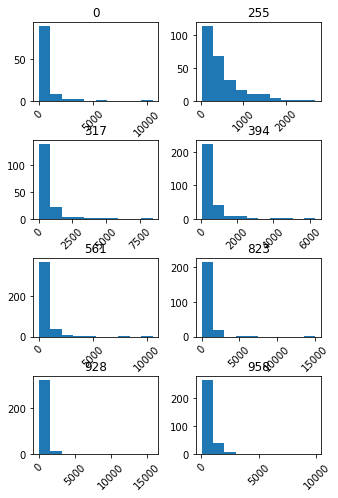

In [10]:
 df.hist('totalprice', by='len_employment', figsize=(5,8), layout=(4,2), xrot=45);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024E9064F320>]],
      dtype=object)

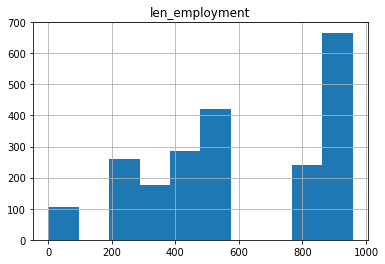

In [23]:
df.hist('len_employment')

In [12]:
tenure = list(df.len_employment.unique())
tenure

[394, 561, 958, 0, 928, 255, 823, 317]

In [13]:
len_0 = df.loc[df['len_employment'] == 0]
len_255 = df.loc[df['len_employment'] == 255]
len_317 = df.loc[df['len_employment'] == 317]
len_394 = df.loc[df['len_employment'] == 394]
len_561 = df.loc[df['len_employment'] == 561]
len_823 = df.loc[df['len_employment'] == 823]
len_928 = df.loc[df['len_employment'] == 928]
len_958 = df.loc[df['len_employment'] == 958]

len_0 = len_0['totalprice']
len_255 = len_255['totalprice']
len_317 = len_317['totalprice']
len_394 = len_394['totalprice']
len_561 = len_561['totalprice']
len_823 = len_823['totalprice']
len_928 = len_928['totalprice']
len_958 = len_958['totalprice']

print('len_0')
print(hf.test_normality(len_0))
print('len_255')
print(hf.test_normality(len_255))
print('len_317')
print(hf.test_normality(len_317))
print('len_394')
print(hf.test_normality(len_394))
print('len_561')
print(hf.test_normality(len_561))
print('len_823')
print(hf.test_normality(len_823))
print('len_928')
print(hf.test_normality(len_928))
print('len_958')
print(hf.test_normality(len_958))

len_0
p= 7.304625194302649e-18
 The data is not normally distributed.
False
len_255
p= 4.103233068163989e-17
 The data is not normally distributed.
False
len_317
p= 6.9448335356879765e-22
 The data is not normally distributed.
False
len_394
p= 1.3690730313917236e-25
 The data is not normally distributed.
False
len_561
p= 1.476363011536015e-32
 The data is not normally distributed.
False
len_823
p= 4.964441884255779e-27
 The data is not normally distributed.
False
len_928
p= 2.0911807932890392e-32
 The data is not normally distributed.
False
len_958
p= 3.4248062893919227e-29
 The data is not normally distributed.
False


In [14]:
len_0mean = np.mean(len_0)
len_0std = np.std(len_0, ddof=1)

samp_len_0 = np.random.normal(loc=len_0mean, scale=len_0std, size=50)
len_255mean = np.mean(len_255)
len_255std = np.std(len_255, ddof=1)

samp_len_255 = np.random.normal(loc=len_255mean, scale=len_255std, size=50)
len_317mean = np.mean(len_317)
len_317std = np.std(len_317, ddof=1)

samp_len_317 = np.random.normal(loc=len_317mean, scale=len_317std, size=50)
len_394mean = np.mean(len_394)
len_394std = np.std(len_394, ddof=1)

samp_len_394 = np.random.normal(loc=len_394mean, scale=len_394std, size=50)
len_561mean = np.mean(len_561)
len_561std = np.std(len_561, ddof=1)

samp_len_561 = np.random.normal(loc=len_561mean, scale=len_561std, size=50)
len_823mean = np.mean(len_823)
len_823std = np.std(len_823, ddof=1)

samp_len_823 = np.random.normal(loc=len_823mean, scale=len_823std, size=50)
len_928mean = np.mean(len_928)
len_928std = np.std(len_928, ddof=1)

samp_len_928 = np.random.normal(loc=len_928mean, scale=len_928std, size=50)
len_958mean = np.mean(len_958)
len_958std = np.std(len_958, ddof=1)

samp_len_958 = np.random.normal(loc=len_958mean, scale=len_958std, size=50)

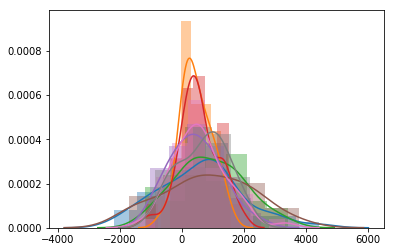

In [15]:
sns.distplot(samp_len_0)
sns.distplot(samp_len_255)
sns.distplot(samp_len_317)
sns.distplot(samp_len_394)
sns.distplot(samp_len_561)
sns.distplot(samp_len_823)
sns.distplot(samp_len_928)
sns.distplot(samp_len_958)

In [16]:
hf.test_normality(samp_len_0)
hf.test_normality(samp_len_255)
hf.test_normality(samp_len_317)
hf.test_normality(samp_len_394)
hf.test_normality(samp_len_561)
hf.test_normality(samp_len_823)
hf.test_normality(samp_len_928)
hf.test_normality(samp_len_958)

p= 0.7015696167945862
 The data is normally distributed.
p= 0.5828062295913696
 The data is normally distributed.
p= 0.7990869283676147
 The data is normally distributed.
p= 0.3618880808353424
 The data is normally distributed.
p= 0.5874108672142029
 The data is normally distributed.
p= 0.4362936019897461
 The data is normally distributed.
p= 0.37614789605140686
 The data is normally distributed.
p= 0.24208180606365204
 The data is normally distributed.


True

In [17]:
hf.test_equal_variance(samp_len_0, samp_len_255)

p= 1.8695281920739244e-06
 Variances are not equal.


False

In [21]:
test_df = pd.DataFrame()
test_df['samp_len_0'] = samp_len_0
test_df['samp_len_255'] = samp_len_255
test_df['samp_len_317'] = samp_len_317
test_df['samp_len_394'] = samp_len_394
test_df['samp_len_561'] = samp_len_561
test_df['samp_len_823'] = samp_len_823
test_df['samp_len_928'] = samp_len_928
test_df['samp_len_958'] = samp_len_958

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024E906F2F60>,
      dtype=object)

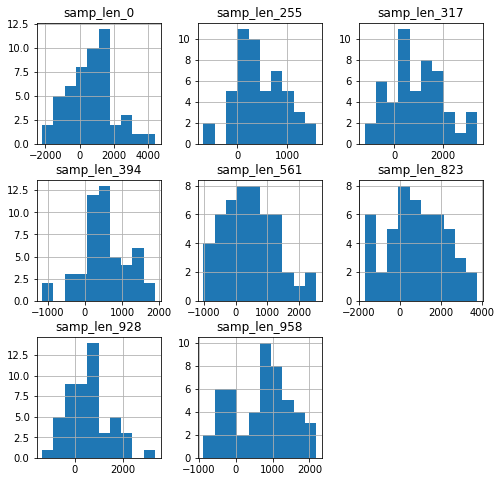

In [24]:
test_df.hist(figsize=(8,8))

In [19]:
formula = 'samp_len_958 ~ samp_len_255 + samp_len_317 + samp_len_394 + samp_len_561 + samp_len_823 + samp_len_928 + samp_len_0'
lm = ols(formula, test_df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           samp_len_958   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     2.184
Date:                Fri, 15 Nov 2019   Prob (F-statistic):             0.0552
Time:                        10:56:00   Log-Likelihood:                -396.78
No. Observations:                  50   AIC:                             809.6
Df Residuals:                      42   BIC:                             824.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      883.2257    221.832      3.982      0.000     435.550    1330.901
samp_len_255    -0.2521      0.240     -1.052      0.299      -0.736       0.231
samp_len_317     0.2007      0.105      1.913      0.063      -0.011       0.412
samp_len_394    -0.3022      0.178     -1.696      0.097      -0.662       0.057
samp_len_561    -0.2476      0.136     -1.821      0.076      -0.522       0.027
samp_len_823     0.1158      0.080      1.456      0.153      -0.045       0.276
samp_len_928    -0.2323      0.132     -1.755      0.087      -0.499       0.035
samp_len_0       0.0861      0.089      0.965      0.340      -0.094       0.266
==============================================================================
Omnibus:                        2.313   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.315   Jarque-Bera (JB):                1.399
Skew:                          -0.083   Prob(JB):                        0.497
Kurtosis:                       2.197   Cond. No.                     4.53e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
H, pval = mstats.kruskalwallis(samp_len_0, samp_len_255, samp_len_317, samp_len_394, samp_len_561, samp_len_823, samp_len_928, samp_len_958)
print('H-stat', H)
print('pvalue', pval)

H-stat 10.207912219451373
pvalue 0.17709425762396017


From the Kruskal_Wallace above, the p-value greater than .05 indicates that the data is of the same distribution
with this result, we __fail to reject our Null H0__